In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

import pickle

#Load training and test data

In [ ]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

In [ ]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 13s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


#Preprocess data

In [ ]:
# Normalize the data. Before we need to connvert data type to float for computation.
images = y_test
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Initialize the neural network

In [ ]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

#Train the neural network
(Accuracy: 82.81% on training dataset)

In [ ]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Not using data augmentation.
Epoch 1/100
1563/1563 [==============================] - 17s 8ms/step - loss: 1.8363 - accuracy: 0.3264 - val_loss: 1.5408 - val_accuracy: 0.4403
Epoch 2/100
1563/1563 [==============================] - 9s 5ms/step - loss: 1.4986 - accuracy: 0.4525 - val_loss: 1.4296 - val_accuracy: 0.4838
Epoch 3/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3566 - accuracy: 0.5137 - val_loss: 1.2282 - val_accuracy: 0.5607
Epoch 4/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2618 - accuracy: 0.5513 - val_loss: 1.1788 - val_accuracy: 0.5843
Epoch 5/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1802 - accuracy: 0.5832 - val_loss: 1.0968 - val_accuracy: 0.6167
Epoch 6/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1120 - accuracy: 0.6078 - val_loss: 1.0195 - val_accuracy: 0.6427
Epoch 7/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0627 - accuracy: 0.

In [ ]:
model.save('/content/drive/MyDrive/Cifar10_CNN/cifar10_model_2.keras')


#Load data and labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/Cifar10_CNN/cifar10_model_2.keras'
c_model = keras.models.load_model(model_path)

In [ ]:
def labels_to_string(label):
    legend_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
                     'truck']
    return legend_labels[label]

In [ ]:
import numpy as np

labels = []

for i in range(0, len(y_test)):
  index = np.argmax(y_test[i])
  labels.append(labels_to_string(index))
labels_arr = np.array(labels)
np.save('/content/drive/MyDrive/Cifar10_CNN/labels.npy', labels_arr)

#Test  the neural network on the test dataset (10.000 image)

In [ ]:
test_images = x_test
batch_size = 32  # Adjust the batch size based on your available memory

predictions = []
num_images = len(test_images)

for i in range(0, num_images, batch_size):
    print(i)
    start_index = i
    end_index = min(i + batch_size, num_images)

    batch_images = test_images[start_index:end_index]
    batch_predictions_array = c_model.predict(batch_images)

    batch_indices = np.argmax(batch_predictions_array, axis=1)
    batch_predictions = [labels_to_string(index) for index in batch_indices]

    predictions.extend(batch_predictions)

predictions_arr = np.array(predictions)
np.save('/content/drive/MyDrive/Cifar10_CNN/predictions.npy', predictions_arr)



0
1/1 [==============================] - 0s 78ms/step
32
1/1 [==============================] - 0s 16ms/step
64
1/1 [==============================] - 0s 16ms/step
96
1/1 [==============================] - 0s 16ms/step
128
1/1 [==============================] - 0s 19ms/step
160
1/1 [==============================] - 0s 16ms/step
192
1/1 [==============================] - 0s 24ms/step
224
1/1 [==============================] - 0s 19ms/step
256
1/1 [==============================] - 0s 19ms/step
288
1/1 [==============================] - 0s 17ms/step
320
1/1 [==============================] - 0s 16ms/step
352
1/1 [==============================] - 0s 17ms/step
384
1/1 [==============================] - 0s 17ms/step
416
1/1 [==============================] - 0s 16ms/step
448
1/1 [==============================] - 0s 27ms/step
480
1/1 [==============================] - 0s 25ms/step
512
1/1 [==============================] - 0s 25ms/step
544
1/1 [==============================] - 0s 26ms/st

# Display falsely predicted images

In [ ]:
false_prediction_indexes = []
mispredictions = []
predictions_arr = np.load('/content/drive/MyDrive/Cifar10_CNN/predictions.npy')
labels_arr = np.load('/content/drive/MyDrive/Cifar10_CNN/labels.npy')
for i in range(0, len(predictions_arr)):
    if(predictions_arr[i]!= labels_arr[i]):
      false_prediction_indexes.append(i)
      mispredictions.append(predictions_arr[i])
false_predictions_indexes_arr = np.array(false_prediction_indexes)
np.save('/content/drive/MyDrive/Cifar10_CNN/false_prediction_indexes.npy', false_predictions_indexes_arr)
np.save('/content/drive/MyDrive/Cifar10_CNN/misprediction_labels.npy', mispredictions)
print("Accuracy on test dataset: " + str( (len(predictions_arr) - len(false_prediction_indexes)) /len(predictions_arr)))

Accuracy on test dataset: 0.7736


Expected label: ship  || Prediction: automobile


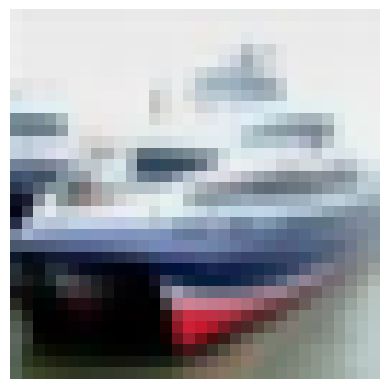




Expected label: ship  || Prediction: automobile


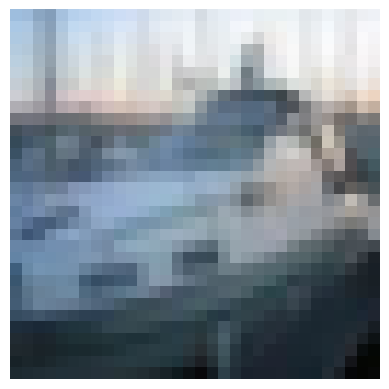

In [ ]:
import matplotlib.pyplot as plt

predictions = np.load('/content/drive/MyDrive/Cifar10_CNN/predictions.npy')
labels = np.load('/content/drive/MyDrive/Cifar10_CNN/labels.npy')
for i in range(0, 2):
    idx = false_prediction_indexes[i]
    print("Expected label: " + labels[idx] + "  || Prediction: "+ predictions[idx])
    image = x_test[idx]
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    print("\n\n")


#Extract feature vectors from falsely predicted images


##Resize and preprocess images for vgg16 (32,32,3) -> (224,224,3)

In [ ]:
from skimage.transform import resize
import cv2

def preprocess_image(img):
    img = resize(img, (224, 224, 3))
    img_n = cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return preprocess_input(img_n.reshape(img.shape[0], img.shape[1], img.shape[2]))

##Get falsely predicted images

In [ ]:
from PIL import Image
from keras.applications.vgg16 import preprocess_input

falsely_predicted_images = []
for i in range(0, len(false_prediction_indexes)):
    idx = false_prediction_indexes[i]

    # Convert the image array to uint8
    img_array = (x_test[idx] * 255).astype('uint8')

    #img = Image.fromarray(img_array)  # Convert NumPy array to PIL Image
    #img_resized = img.resize((224, 224))
    falsely_predicted_images.append(np.array(img_array))

falsely_predicted_images_arr = np.stack(falsely_predicted_images)
np.save('/content/drive/MyDrive/Cifar10_CNN/falsely_predicted_images.npy', falsely_predicted_images_arr)


## Initialize VGG16

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(include_top=False, pooling='avg')



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

##Extract feature vectors from falsely predicted images

In [ ]:
images = np.load('/content/drive/MyDrive/Cifar10_CNN/falsely_predicted_images.npy')
feature_vectors = []
batch_size= 32
num_images = len(images)

for i in range(0, num_images, batch_size):
    print(i)
    start_index = i
    end_index = min(i + batch_size, num_images)

    batch_images = images[start_index:end_index]
    preprocessed_batch_images = np.array([preprocess_image(img) for img in batch_images])
    batch_vectors = conv_base.predict(preprocessed_batch_images)

    feature_vectors.append(batch_vectors)

feature_vectors_arr = np.concatenate(feature_vectors, axis=0)
np.save('/content/drive/MyDrive/Cifar10_CNN/feature_vectors.npy', feature_vectors_arr)



0
1/1 [==============================] - 0s 42ms/step
32
1/1 [==============================] - 0s 35ms/step
64
1/1 [==============================] - 0s 42ms/step
96
1/1 [==============================] - 0s 27ms/step
128
1/1 [==============================] - 0s 25ms/step
160
1/1 [==============================] - 0s 26ms/step
192
1/1 [==============================] - 0s 25ms/step
224
1/1 [==============================] - 0s 25ms/step
256
1/1 [==============================] - 0s 26ms/step
288
1/1 [==============================] - 0s 25ms/step
320
1/1 [==============================] - 0s 25ms/step
352
1/1 [==============================] - 0s 25ms/step
384
1/1 [==============================] - 0s 26ms/step
416
1/1 [==============================] - 0s 28ms/step
448
1/1 [==============================] - 0s 26ms/step
480
1/1 [==============================] - 0s 28ms/step
512
1/1 [==============================] - 0s 26ms/step
544
1/1 [==============================] - 0s 25ms/st

#Dimension reduction

In [ ]:
!pip install umap-learn
import umap.umap_ as umap


# Load the feature vectors
feature_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/feature_vectors.npy')


# Apply UMAP
umap_model = umap.UMAP(n_neighbors=20, min_dist=0.8, n_components=2)
reduced_vectors = umap_model.fit_transform(feature_vectors)

# Save the reduced vectors
np.save('/content/drive/MyDrive/Cifar10_CNN/umap_vectors.npy', reduced_vectors)



In [ ]:
labels = np.load('/content/drive/MyDrive/Cifar10_CNN/labels.npy')
false_prediction_indexes = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_indexes.npy')

false_prediction_labels = []
for i in range (0, len(false_prediction_indexes)):
  idx = false_prediction_indexes[i]
  false_prediction_labels.append(labels[idx])
false_prediction_labels = np.array(false_prediction_labels)
np.save('/content/drive/MyDrive/Cifar10_CNN/false_prediction_labels.npy', false_prediction_labels)

##Scatter 2d vectors

In [ ]:
def num_from_label(label):
  color_map = {'airplane': 1, 'automobile': 2, 'bird': 3, 'cat': 4, 'deer': 5, 'dog': 6, 'frog': 7, 'horse': 8,
                     'ship': 9, 'truck': 10}
  return color_map[label]


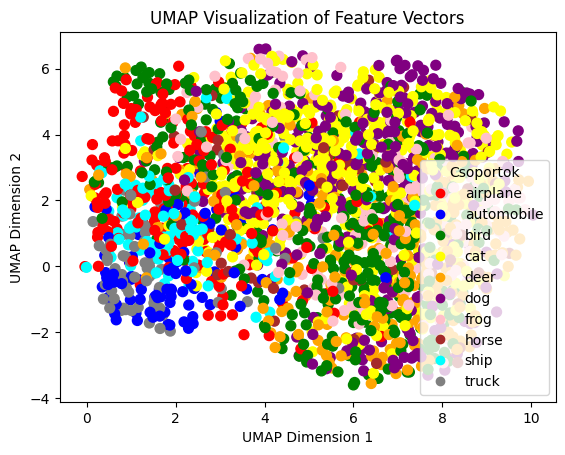

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the reduced vectors from UMAP
reduced_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/umap_vectors.npy')
#color the points
false_prediction_labels = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_labels.npy')
labels = []
for label in false_prediction_labels:
  labels.append(num_from_label(label))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'cyan', 'gray']
cmap = ListedColormap(colors)

# Scatter plot
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o', c=labels,  cmap=cmap , s=50)
plt.title('UMAP Visualization of Feature Vectors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

legend_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
                     'truck']
plt.legend(scatter.legend_elements()[0], legend_labels, title='Csoportok')
plt.show()

###Scatter with the mispredicted labels

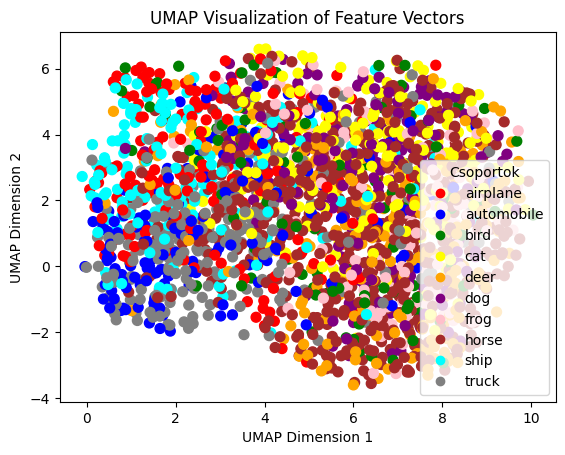

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the reduced vectors from UMAP
reduced_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/umap_vectors.npy')
#color the points
false_prediction_labels = np.load('/content/drive/MyDrive/Cifar10_CNN/misprediction_labels.npy')
labels = []
for label in false_prediction_labels:
  labels.append(num_from_label(label))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'cyan', 'gray']
cmap = ListedColormap(colors)

# Scatter plot
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o', c=labels,  cmap=cmap , s=50)
plt.title('UMAP Visualization of Feature Vectors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

legend_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
                     'truck']
plt.legend(scatter.legend_elements()[0], legend_labels, title='Csoportok')
plt.show()

#Clustering for all images

In [ ]:
images = (x_test* 255).astype('uint8')
feature_vectors = []
batch_size= 32
num_images = len(images)

for i in range(0, num_images, batch_size):
    print(i)
    start_index = i
    end_index = min(i + batch_size, num_images)

    batch_images = x_test[start_index:end_index]
    preprocessed_batch_images = np.array([preprocess_image(img) for img in batch_images])
    batch_vectors = conv_base.predict(preprocessed_batch_images)

    feature_vectors.append(batch_vectors)

feature_vectors_arr = np.concatenate(feature_vectors, axis=0)
np.save('/content/drive/MyDrive/Cifar10_CNN/feature_vectors_all_images.npy', feature_vectors_arr)



0
1/1 [==============================] - 0s 36ms/step
32
1/1 [==============================] - 0s 36ms/step
64
1/1 [==============================] - 0s 26ms/step
96
1/1 [==============================] - 0s 26ms/step
128
1/1 [==============================] - 0s 28ms/step
160
1/1 [==============================] - 0s 25ms/step
192
1/1 [==============================] - 0s 25ms/step
224
1/1 [==============================] - 0s 24ms/step
256
1/1 [==============================] - 0s 29ms/step
288
1/1 [==============================] - 0s 25ms/step
320
1/1 [==============================] - 0s 31ms/step
352
1/1 [==============================] - 0s 26ms/step
384
1/1 [==============================] - 0s 31ms/step
416
1/1 [==============================] - 0s 29ms/step
448
1/1 [==============================] - 0s 33ms/step
480
1/1 [==============================] - 0s 25ms/step
512
1/1 [==============================] - 0s 25ms/step
544
1/1 [==============================] - 0s 28ms/st

In [ ]:
#!pip install umap-learn
import umap.umap_ as umap

from sklearn.preprocessing import StandardScaler

# Load the feature vectors
feature_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/feature_vectors_all_images.npy')

# Standardize the feature vectors
#scaler = StandardScaler()
#standardized_feature_vectors = scaler.fit_transform(reshaped_feature_vectors)

# Apply UMAP
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.8, n_components=2)
reduced_vectors = umap_model.fit_transform(feature_vectors)

# Save the reduced vectors
np.save('/content/drive/MyDrive/Cifar10_CNN/umap_vectors_all_images.npy', reduced_vectors)

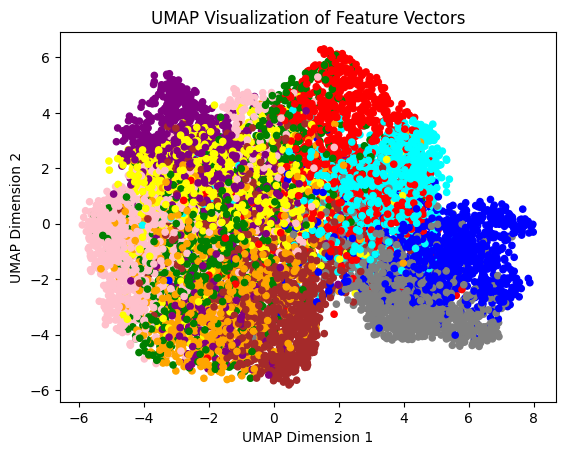

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the reduced vectors from UMAP
vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/umap_vectors_all_images.npy')

#color the points
labels = np.load('/content/drive/MyDrive/Cifar10_CNN/labels.npy')
labels_arr = []
for label in labels:
  labels_arr.append(num_from_label(label))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'cyan', 'gray']
cmap = ListedColormap(colors)

# Scatter plot
plt.scatter(vectors[:, 0], vectors[:, 1], marker='o', c=labels_arr,  cmap=cmap , s=20)
plt.title('UMAP Visualization of Feature Vectors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


#Dimension reduction with PCA

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Load the feature vectors
feature_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/feature_vectors.npy')

# Apply PCA
pca_model = PCA(n_components=2)
reduced_vectors_pca = pca_model.fit_transform(feature_vectors)

# Save the reduced vectors
np.save('/content/drive/MyDrive/Cifar10_CNN/pca_vectors.npy', reduced_vectors_pca)


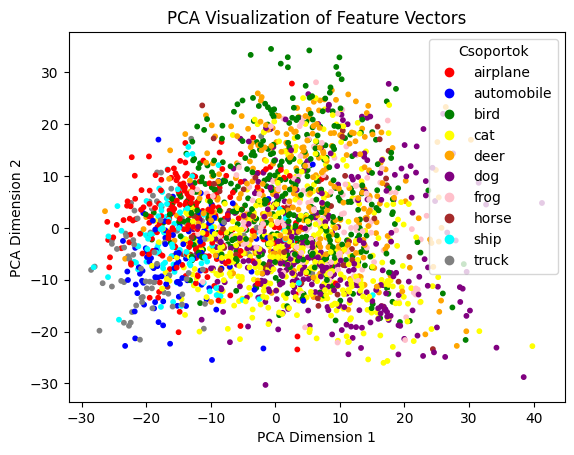

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the reduced vectors from UMAP
reduced_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/pca_vectors.npy')
#color the points
false_prediction_labels = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_labels.npy')
labels = []
for label in false_prediction_labels:
  labels.append(num_from_label(label))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'cyan', 'gray']
cmap = ListedColormap(colors)

# Scatter plot
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o', c=labels,  cmap=cmap , s=10)
plt.title('PCA Visualization of Feature Vectors')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

legend_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
                     'truck']
plt.legend(scatter.legend_elements()[0], legend_labels, title='Csoportok')
plt.show()

#Adding the label pairs to the feature vector, and repeat the clustering

In [ ]:
# Load the feature vectors
feature_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/feature_vectors.npy')
actual_labels = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_labels.npy')
misprediction_labels = np.load('/content/drive/MyDrive/Cifar10_CNN/misprediction_labels.npy')

#convert labels to numbers
numerized_actual_labels = []
for label in actual_labels:
  numerized_actual_labels.append(num_from_label(label))

numerized_misprediction_labels = []
for label in misprediction_labels:
  numerized_misprediction_labels.append(num_from_label(label))

extended_feature_vectors = []
for i in range(0,len(feature_vectors)):
  extended_vector = np.append(feature_vectors[i], [numerized_actual_labels[i], numerized_misprediction_labels[i]])
  extended_feature_vectors.append(extended_vector)

extended_feature_vectors= np.array(extended_feature_vectors)
print(extended_feature_vectors.shape)
np.save('/content/drive/MyDrive/Cifar10_CNN/extened_feature_vectors.npy',extended_feature_vectors)

(2264, 514)


In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Load the feature vectors
feature_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/extened_feature_vectors.npy')

# Apply PCA
pca_model = PCA(n_components=2)
reduced_vectors_pca = pca_model.fit_transform(feature_vectors)

# Save the reduced vectors
np.save('/content/drive/MyDrive/Cifar10_CNN/pca_extended_vectors.npy', reduced_vectors_pca)

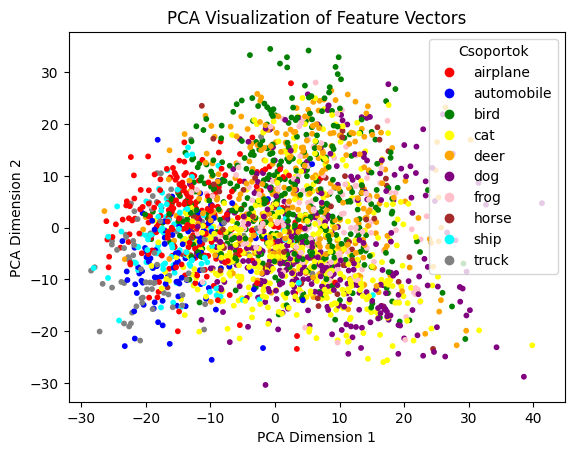

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the reduced vectors from UMAP
reduced_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/pca_extended_vectors.npy')
#color the points
false_prediction_labels = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_labels.npy')
labels = []
for label in false_prediction_labels:
  labels.append(num_from_label(label))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'cyan', 'gray']
cmap = ListedColormap(colors)

# Scatter plot
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o', c=labels,  cmap=cmap , s=10)
plt.title('PCA Visualization of Feature Vectors')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

legend_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',
                     'truck']
plt.legend(scatter.legend_elements()[0], legend_labels, title='Csoportok')
plt.show()

#DBSCAN

Number of clusters: 51


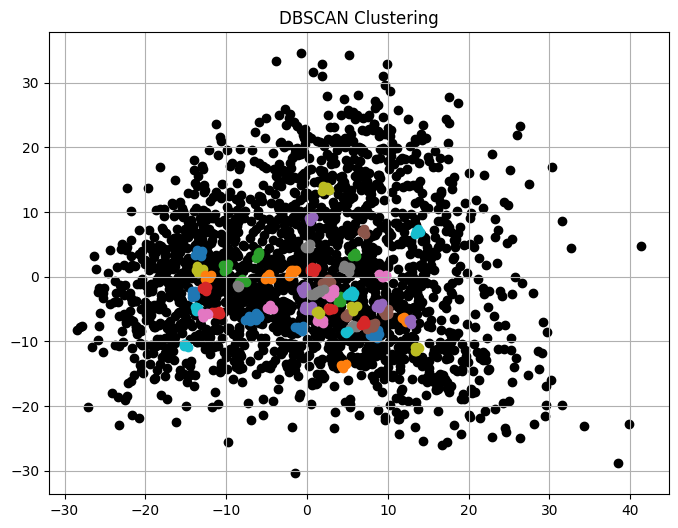

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Load the 2D feature vectors
feature_vectors_2d = np.load('/content/drive/MyDrive/Cifar10_CNN/pca_extended_vectors.npy')

# Create a DBSCAN instance
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to your 2D data
dbscan.fit(feature_vectors_2d)

# Get the cluster labels assigned by DBSCAN
cluster_labels = dbscan.labels_

# Get the number of clusters (-1 indicates outliers)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Number of clusters:", num_clusters)

# Scatter plot the points colored by cluster labels
plt.figure(figsize=(8, 6))
cluster_indices = [[] for _ in range(num_clusters)]
for label in range(-1, num_clusters):
    if label == -1:
        # Outliers
        plt.scatter(feature_vectors_2d[cluster_labels == label][:, 0],
                    feature_vectors_2d[cluster_labels == label][:, 1],
                    color='black', marker='o', label='Outliers')
    else:
        # Clustered points
        cluster_points = feature_vectors_2d[cluster_labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
        # Get indices of 3 samples from each cluster
        cluster_indices[label] = np.random.choice(np.where(cluster_labels == label)[0], size=min(3, len(cluster_points)), replace=False).tolist()

plt.title('DBSCAN Clustering')
plt.grid(True)
plt.show()


cluster_indices = np.array(cluster_indices)
np.save('/content/drive/MyDrive/Cifar10_CNN/cluster_indices.npy', cluster_indices)


##Display images

Expected label: bird  || Prediction: cat


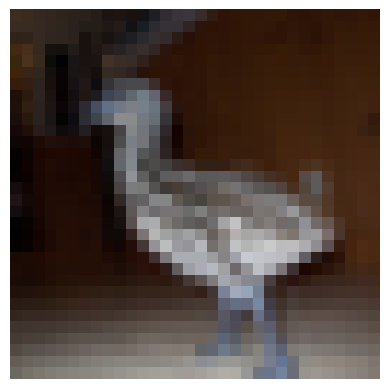




Expected label: truck  || Prediction: frog


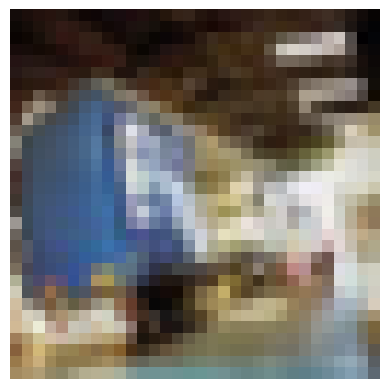




Expected label: bird  || Prediction: airplane


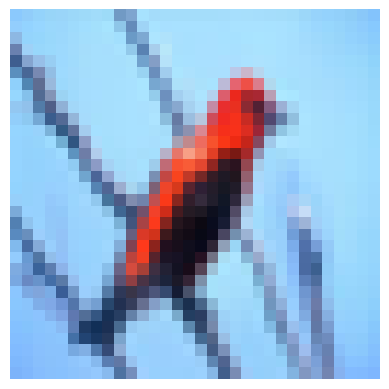

In [ ]:
import matplotlib.pyplot as plt

cluster_indices = np.load('/content/drive/MyDrive/Cifar10_CNN/cluster_indices.npy')
images = np.load('/content/drive/MyDrive/Cifar10_CNN/falsely_predicted_images.npy')


predictions = np.load('/content/drive/MyDrive/Cifar10_CNN/misprediction_labels.npy')
labels = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_labels.npy')



for i in range(0, 3):
    idx = cluster_indices[40][i]
    print("Expected label: " + labels[idx] + "  || Prediction: "+ predictions[idx])
    image = images[idx]
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    print("\n\n")

#DBSCAN on Clevr feature vectors

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Load the feature vectors
feature_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/clevr_feature_vectors.npy')

# Apply PCA
pca_model = PCA(n_components=2)
reduced_vectors_pca = pca_model.fit_transform(feature_vectors)

# Save the reduced vectors
np.save('/content/drive/MyDrive/Cifar10_CNN/pca_vectors_clevr.npy', reduced_vectors_pca)

(10000, 2)
Number of clusters: 0


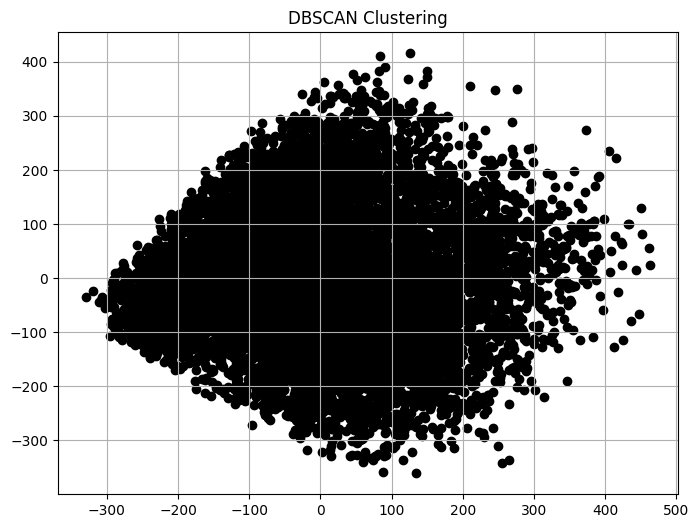

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Load the 2D feature vectors
feature_vectors_2d = np.load('/content/drive/MyDrive/Cifar10_CNN/pca_vectors_clevr.npy')
print(feature_vectors_2d.shape)
# Create a DBSCAN instance
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to your 2D data
dbscan.fit(feature_vectors_2d)

# Get the cluster labels assigned by DBSCAN
cluster_labels = dbscan.labels_

# Get the number of clusters (-1 indicates outliers)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Number of clusters:", num_clusters)

# Scatter plot the points colored by cluster labels
plt.figure(figsize=(8, 6))
cluster_indices = [[] for _ in range(num_clusters)]
for label in range(-1, num_clusters):
    if label == -1:
        # Outliers
        plt.scatter(feature_vectors_2d[cluster_labels == label][:, 0],
                    feature_vectors_2d[cluster_labels == label][:, 1],
                    color='black', marker='o', label='Outliers')
    else:
        # Clustered points
        cluster_points = feature_vectors_2d[cluster_labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
        # Get indices of 3 samples from each cluster
        cluster_indices[label] = np.random.choice(np.where(cluster_labels == label)[0], size=min(3, len(cluster_points)), replace=False).tolist()

plt.title('DBSCAN Clustering')
plt.grid(True)
plt.show()


cluster_indices = np.array(cluster_indices)
np.save('/content/drive/MyDrive/Cifar10_CNN/cluster_indices_clevr.npy', cluster_indices)


#Inspect data

##Ships, mispredicted as automobile

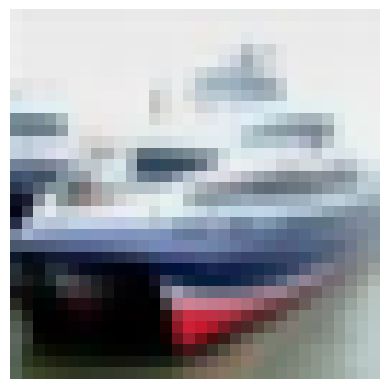

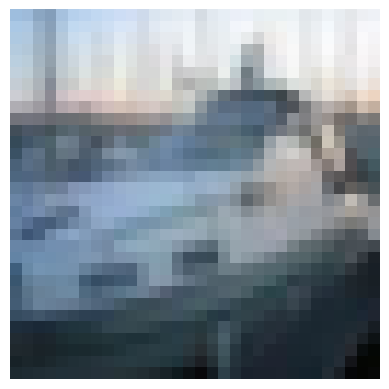

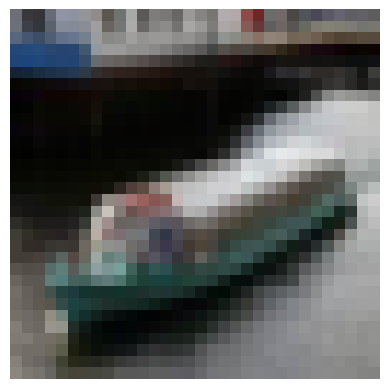

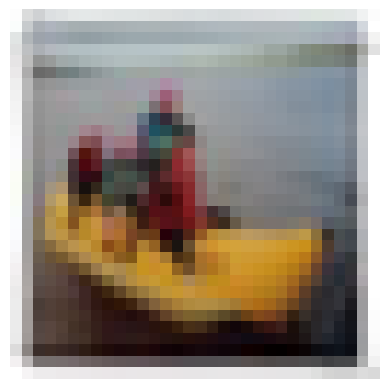

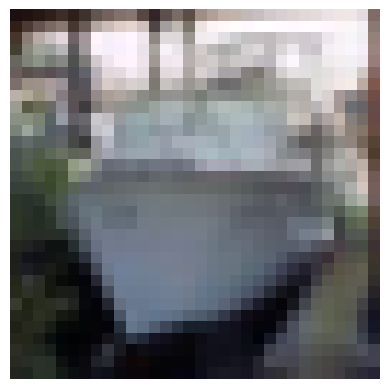

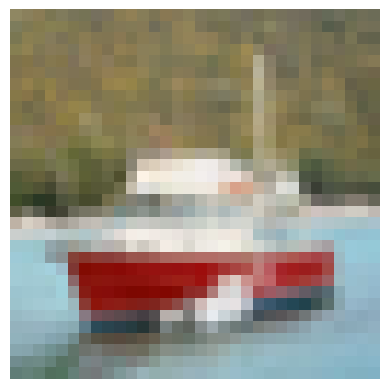

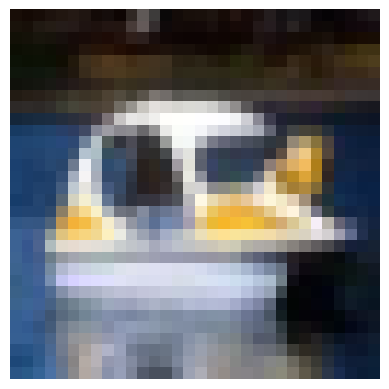

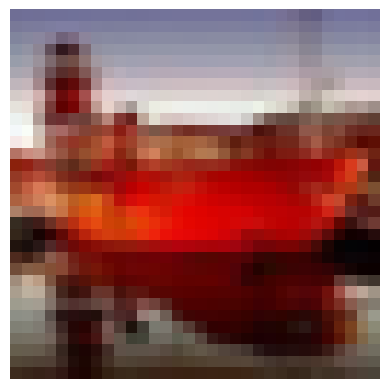

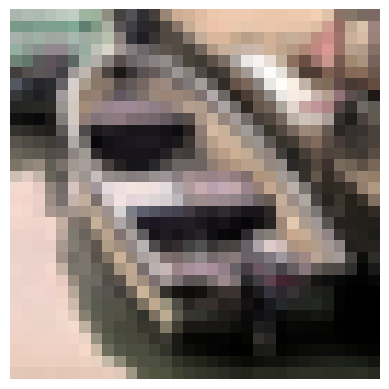

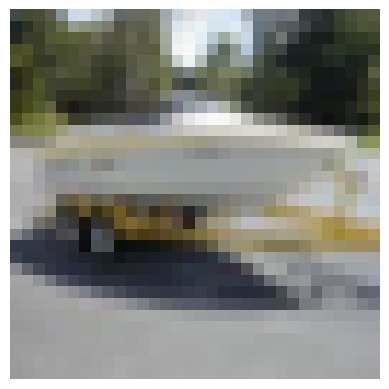

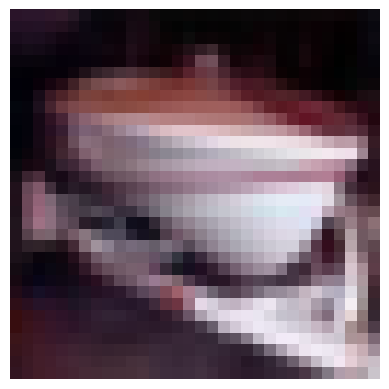

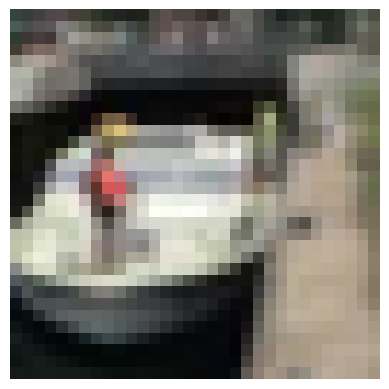

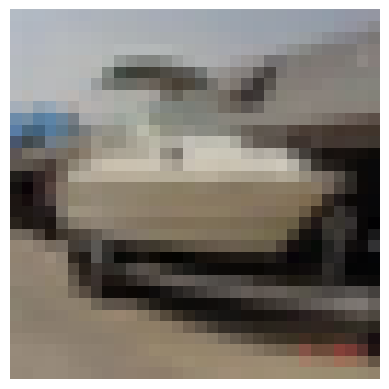

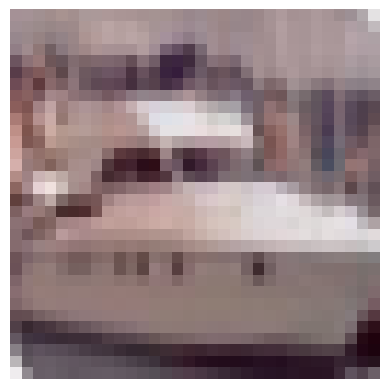

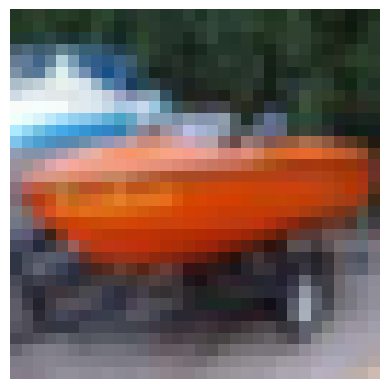

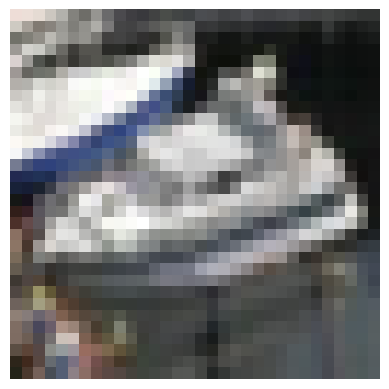

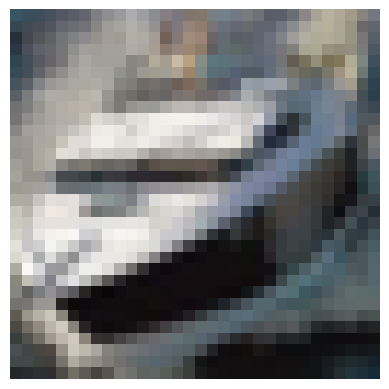

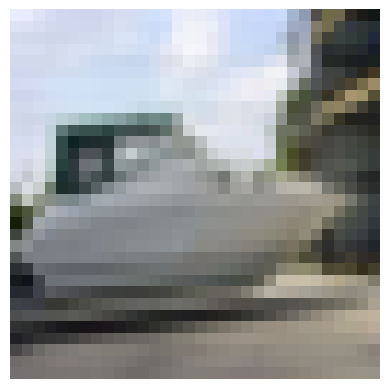

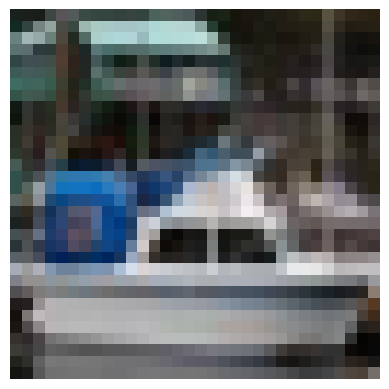

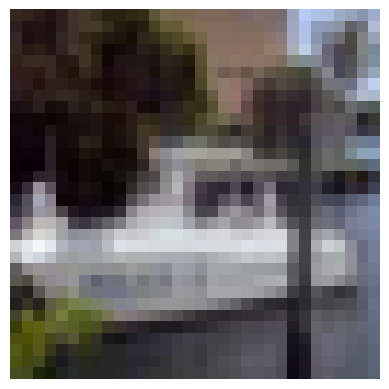

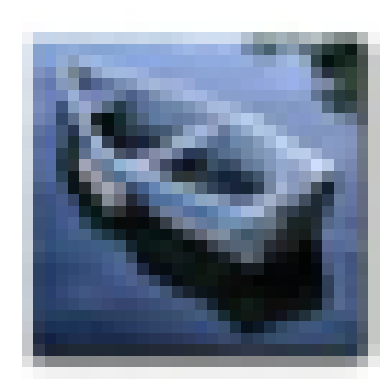

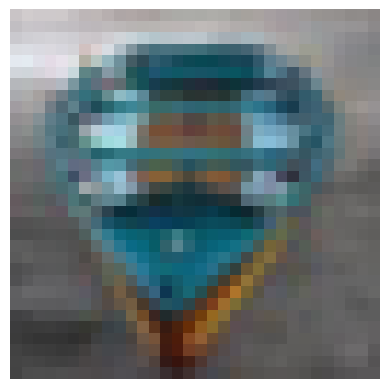

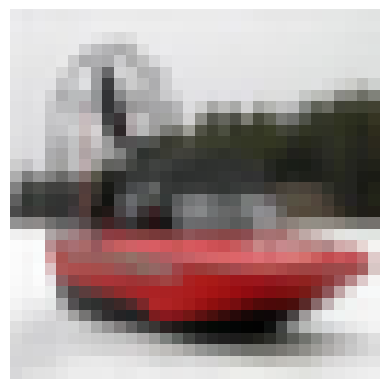

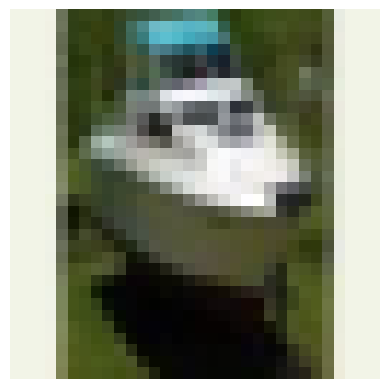

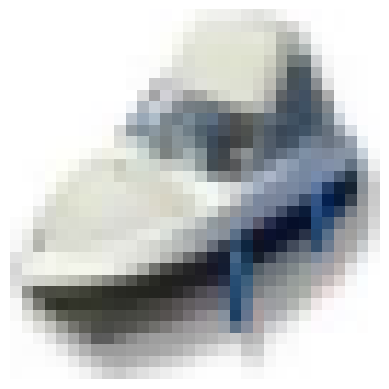

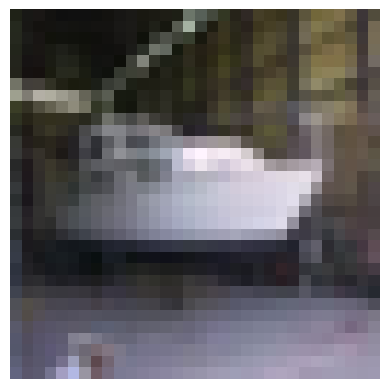

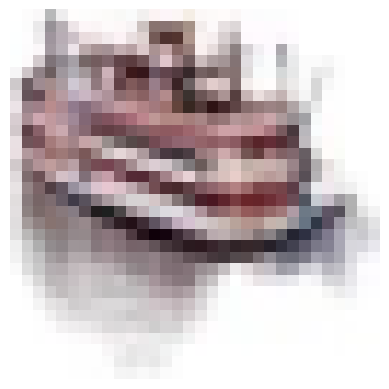

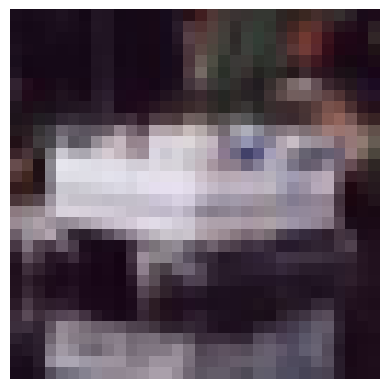

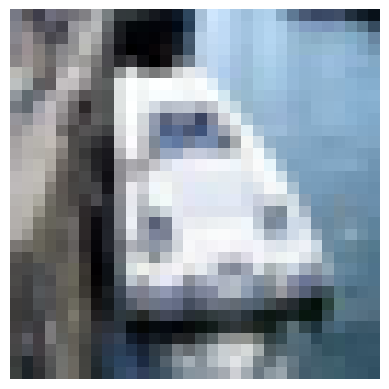

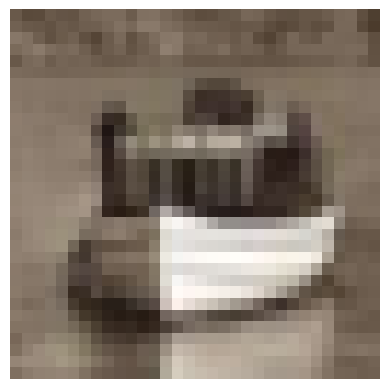




30


In [ ]:
import matplotlib.pyplot as plt

false_prediction_indexes = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_indexes.npy')
predictions = np.load('/content/drive/MyDrive/Cifar10_CNN/predictions.npy')
labels = np.load('/content/drive/MyDrive/Cifar10_CNN/labels.npy')

ship_automobile_indexes = []
for i in range(0, len(false_prediction_indexes)):
    idx = false_prediction_indexes[i]
    image = x_test[idx]
    if (labels[idx] == 'ship' and predictions[idx] == 'automobile'):
      ship_automobile_indexes.append(idx)
      plt.imshow(image)
      plt.axis('off')  # Turn off axis labels
      plt.show()
      print("\n\n")


print(len(ship_automobile_indexes))
ship_automobile_indexes_arr = np.array(ship_automobile_indexes)
np.save('/content/drive/MyDrive/Cifar10_CNN/ship_automobile_indexes.npy', ship_automobile_indexes_arr)

##Automobile, mispredicted as ship

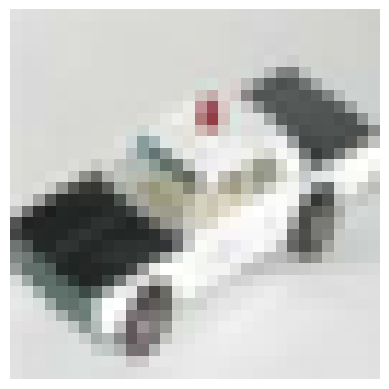

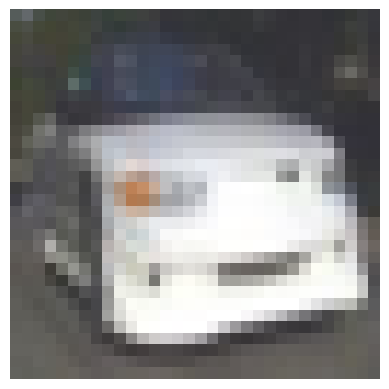

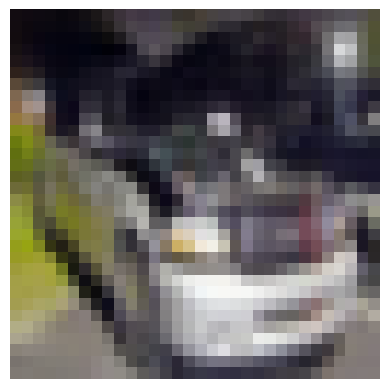

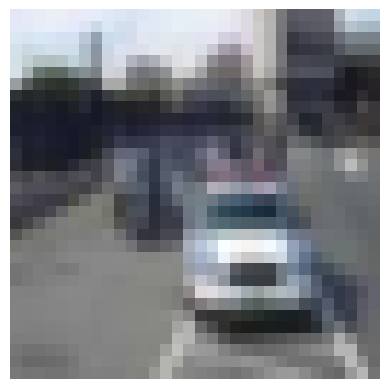

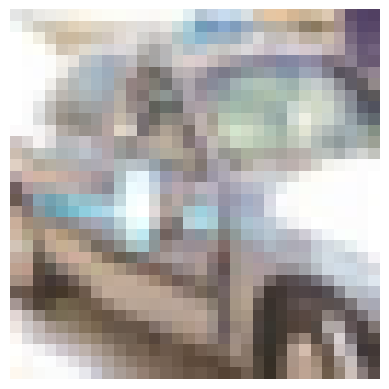

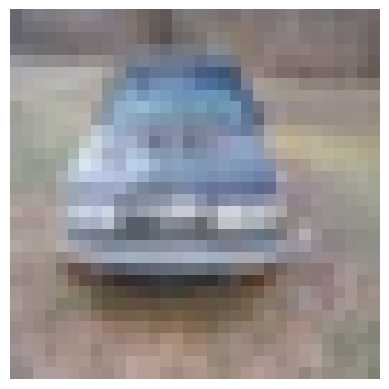

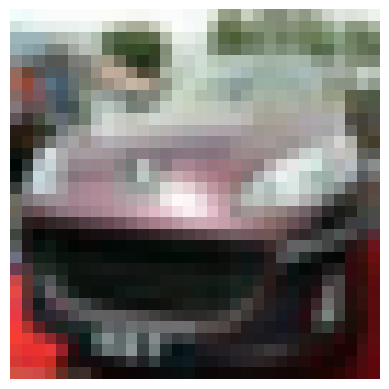

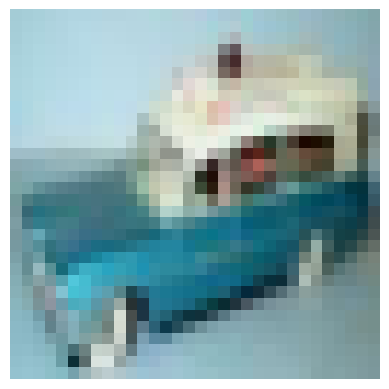

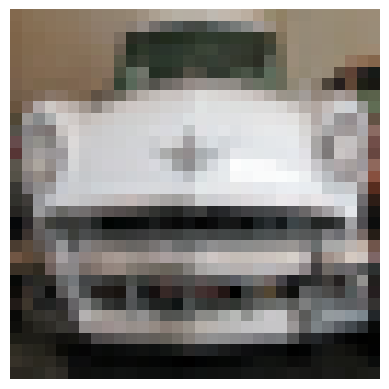




9


In [ ]:
import matplotlib.pyplot as plt

false_prediction_indexes = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_indexes.npy')
predictions = np.load('/content/drive/MyDrive/Cifar10_CNN/predictions.npy')
labels = np.load('/content/drive/MyDrive/Cifar10_CNN/labels.npy')

ship_automobile_indexes = []
for i in range(0, len(false_prediction_indexes)):
    idx = false_prediction_indexes[i]
    image = x_test[idx]
    if (labels[idx] == 'automobile' and predictions[idx] == 'ship'):
      ship_automobile_indexes.append(idx)
      plt.imshow(image)
      plt.axis('off')  # Turn off axis labels
      plt.show()
      print("\n\n")


print(len(ship_automobile_indexes))
ship_automobile_indexes_arr = np.array(ship_automobile_indexes)
np.save('/content/drive/MyDrive/Cifar10_CNN/automobile_ship_indexes.npy', ship_automobile_indexes_arr)

#Umap clustering to 250 dimension

In [ ]:

import umap.umap_ as umap

from sklearn.preprocessing import StandardScaler

# Load the feature vectors
feature_vectors = np.load('/content/drive/MyDrive/Cifar10_CNN/extened_feature_vectors.npy')



# Apply UMAP
fit = umap.UMAP(n_neighbors=10, min_dist=0.03, n_components=300)
partly_reduced_vectors = fit.fit_transform(feature_vectors)
fit = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=250)
reduced_vectors = fit.fit_transform(partly_reduced_vectors)

# Save the reduced vectors
np.save('/content/drive/MyDrive/Cifar10_CNN/umap_250_falsely_predicted_images.npy', reduced_vectors)

##HDBSCAN on reduced vectors (250 dim)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 25.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039275 sha256=7aeca42d3b532184398799b0223e0d5e0fa83f9379d4cc73d5f1a3a5c43807c0
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9
Number of clusters: 193


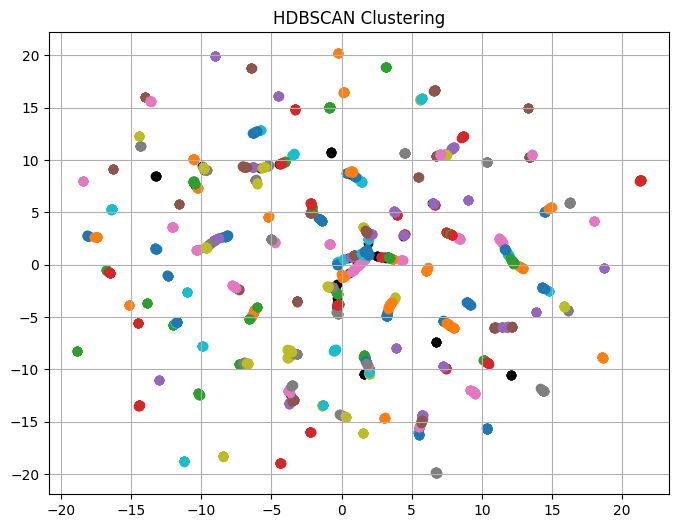

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install hdbscan
import hdbscan
import umap

# Load the feature vectors
feature_vectors_250 = np.load('/content/drive/MyDrive/Cifar10_CNN/umap_250_falsely_predicted_images.npy')

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2)
feature_vectors_2d = umap_model.fit_transform(feature_vectors_250)

# Create an HDBSCAN instance
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5)

# Fit the HDBSCAN model to your 2D data
hdbscan_labels = hdbscan_model.fit_predict(feature_vectors_2d)

# Get the number of clusters (-1 indicates outliers)
num_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
print("Number of clusters:", num_clusters)

# Scatter plot the points colored by cluster labels
plt.figure(figsize=(8, 6))
cluster_indices = [[] for _ in range(num_clusters)]
for label in range(-1, num_clusters):
    if label == -1:
        # Outliers
        plt.scatter(feature_vectors_2d[hdbscan_labels == label][:, 0],
                    feature_vectors_2d[hdbscan_labels == label][:, 1],
                    color='black', marker='o', label='Outliers')
    else:
        # Clustered points
        cluster_points = feature_vectors_2d[hdbscan_labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
        # Get indices of 3 samples from each cluster
        cluster_indices[label] = np.random.choice(np.where(hdbscan_labels == label)[0], size=min(3, len(cluster_points)), replace=False).tolist()

plt.title('HDBSCAN Clustering')
plt.grid(True)
plt.show()

# Save cluster indices
cluster_indices = np.array(cluster_indices)
np.save('/content/drive/MyDrive/Cifar10_CNN/umap250_cluster_indices.npy', cluster_indices)


###Inspect Data


(2264, 32, 32, 3)
Expected label: airplane  || Prediction: ship


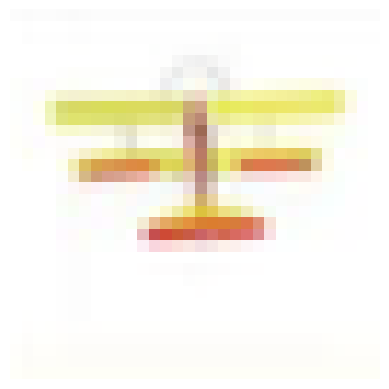




Expected label: airplane  || Prediction: ship


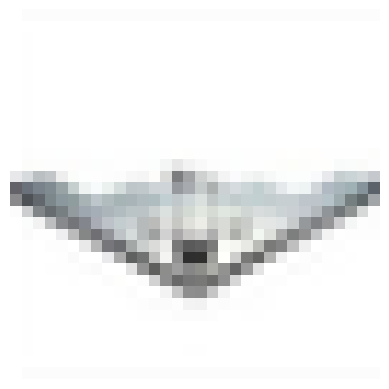




Expected label: airplane  || Prediction: ship


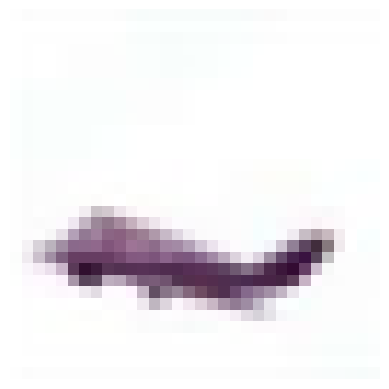

In [ ]:
import matplotlib.pyplot as plt

cluster_indices = np.load('/content/drive/MyDrive/Cifar10_CNN/umap250_cluster_indices.npy')
images = np.load('/content/drive/MyDrive/Cifar10_CNN/falsely_predicted_images.npy')

print(images.shape)

predictions = np.load('/content/drive/MyDrive/Cifar10_CNN/misprediction_labels.npy')
labels = np.load('/content/drive/MyDrive/Cifar10_CNN/false_prediction_labels.npy')



for i in range(0, 3):
  current_idx = cluster_indices[46][i]
  print("Expected label: " + labels[current_idx] + "  || Prediction: "+ predictions[current_idx])
  image = images[current_idx]
  plt.imshow(image)
  plt.axis('off')  # Turn off axis labels
  plt.show()
  print("\n\n")
